<a href="https://colab.research.google.com/github/a-maksimov/data_analysis/blob/main/tweepy_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook downloads twitter timeline of a user (3200 tweets max), preprocess the tweets and trains a word2vec model and tries to generate a sensible sentence.

# Set up the environment

In [1]:
!pip --quiet install tweepy

In [2]:
!pip --quiet install python-dotenv

In [3]:
!pip --quiet install langdetect

In [4]:
!pip --quiet install spacy

In [5]:
!pip --quiet install spacy-langdetect

In [ ]:
#@title Download spaCy language packs

!python -m spacy download ru_core_news_sm --quiet
!python -m spacy download en_core_web_sm --quiet

In [7]:
#@title Imports
import tweepy
from dotenv import load_dotenv
import time
from datetime import datetime
import os
import json
import csv
import pandas as pd
import re
import string
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from collections import defaultdict
import multiprocessing
from gensim.models import Word2Vec
from random import randint
import pdb

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
load_dotenv('/content/drive/MyDrive/Secrets/.env')

True

# Download tweets

In [9]:
consumer_key=os.getenv('consumer_key')
consumer_secret=os.getenv('consumer_secret')
access_token_key=os.getenv('access_token_key')
access_token_secret=os.getenv('access_token_secret')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)

api = tweepy.API(auth)

In [10]:
#@title Twitter username and number of their tweets to download
twitter_username = 'msvetov' #@param {type:"string"}
tweets_count = 3200 #@param {type:"integer"}
language = "ru" #@param ["ru", "en"]
user = api.get_user(twitter_username)

In [ ]:
#@title Fetch the tweets from Twitter
data = []
step = 200
data.extend(tweepy.Cursor(api.user_timeline, tweet_mode='extended', screen_name=twitter_username).items(step))
print(f'..{len(data)} tweets downloaded')
oldest = data[-1].id - 1
time.sleep(1)
for i in range(0, tweets_count - step, step):  
  print(f'getting tweets before id: {oldest}')
  # all subsequent requests use the max_id param to prevent duplicates
  data.extend(tweepy.Cursor(api.user_timeline, tweet_mode='extended', screen_name=twitter_username, max_id=oldest).items(step))
  # update the id of the oldest like minus one
  oldest = data[-1].id - 1
  print(f'..{len(data)} tweets downloaded')
  time.sleep(1)

In [12]:
#@title Save tweets to a csv file
dt_string = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
fieldnames = ['id', 'text']
filename = f'{twitter_username}_{tweets_count}_{dt_string}.csv'
filepath = os.path.join(os.getcwd(), 'tweets/')

if not os.path.exists(filepath):
  os.mkdir(filepath)
with open(filepath + filename, 'w', encoding='utf-8') as file:
  writer = csv.DictWriter(file, fieldnames=fieldnames, extrasaction='ignore')
  writer.writeheader()   
  for tweet in data:
    try: # get full text if tweet is a retweet
      tweet_dict = dict(zip(fieldnames, [tweet.id, tweet.retweeted_status.full_text]))
    except:
      tweet_dict = dict(zip(fieldnames, [tweet.id, tweet.full_text]))
    writer.writerow(tweet_dict)

# Cleaning



In [13]:
#@title import to Pandas
df = pd.read_csv('/content/tweets/' + filename)

In [14]:
#@title Remove meantions, urls, RTs, emojis, symbols
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def brief_clean(text):
  text = re.sub('@[^\s]*\s', '', text)  # remove mentions
  text = text.replace('RT', '')  # remove RTs
  text = re.sub('http\S*', '', text)  # remove urls
  text = remove_emoji(text)  # remove emojis
  text = text.translate(str.maketrans('', '', string.punctuation + '«»——–…“©↓'))  # remove string.punctuation from the string
  text = text.replace('\n', ' ')  # replace newlines with space
  text = re.sub(' +', ' ', text)  # replace multiple spaces with one space
  text = text.lower().strip()  # make all lowercase and strip
  return text

In [15]:
df['text_cleaned'] = df['text'].map(brief_clean)

In [16]:
df['text_cleaned'].duplicated().sum()

196

We drop duplicate tweets after brief cleaning

In [17]:
df = df.drop_duplicates('text_cleaned')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 0 to 3199
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3004 non-null   int64 
 1   text          3004 non-null   object
 2   text_cleaned  3004 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


We reset index

In [18]:
df = df.reset_index(drop=True)

We load spaCy language packs

In [19]:
language = "ru" #@param ["ru", "en"]
if language == 'ru':
  nlp = spacy.load('ru_core_news_sm')  # disabling Named Entity Recognition for speed
else:
  nlp = spacy.load('en_core_web_sm')  # disabling Named Entity Recognition for speed

In [20]:
#@title Now we lemmatize without words
# Lemmatizes and removes stopwords
# doc needs to be a spacy Doc object

def lemmatize_without_stops(doc):
  text = [token.lemma_ for token in doc if not token.is_stop]
  # Word2Vec uses context words to learn the vector representation of a target word,
  # if a sentence is only one or two words long,
  # the benefit for the training is very small
  if len(text) > 2:
    return ' '.join(text)

Taking advantage of spaCy .pipe() method to speed-up the cleaning process:

In [21]:
#@title Add language detector to a spaCy pipeline
def get_lang_detector(nlp, name):
    return LanguageDetector()
Language.factory('language_detector', func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [51]:
docs = nlp.pipe(df['text_cleaned'], batch_size=3000, n_process=-1)  # returns a generator of spacy Docs

t = time.time()

# Lemmitize tweets in specific language
df['text_lem'] = pd.Series([lemmatize_without_stops(doc) if doc._.language['language'] == language else None for doc in docs])

print(f'Time to lemmatize: {round((time.time() - t), 2)} secs')

Time to lemmatize: 81.29 secs


In [52]:
df_clean = df.dropna().copy()

In [53]:
#@title Calculate word frequency

words_freq = defaultdict(int)
for tweet in df_clean['text_lem'].values:
  for word in tweet.split():
    words_freq[word] += 1

word_freq_df = pd.DataFrame.from_dict(words_freq, orient='index', columns=['word_count']).reset_index().rename(columns = {'index': 'word'})
word_freq_df.sort_values('word_count', ascending=False).head(10)

,word,word_count
6,человек,453
476,россия,356
426,путин,317
450,год,285
203,война,271
258,государство,177
773,сегодня,157
607,украина,148
310,против,142
406,страна,135


## Bigrams

We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.

https://radimrehurek.com/gensim/models/phrases.html

In [54]:
from gensim.models.phrases import Phrases, Phraser

Phrases() takes a list of list of words as input:

In [55]:
sent = [row.split() for row in df_clean['text_lem']]

Creates the relevant phrases from the list of sentences:

In [56]:
phrase_model = Phrases(sent, min_count=15)

In [57]:
bigram = Phraser(phrase_model)

In [58]:
sentences = bigram[sent]

In [59]:
#@title Show bigrams
bigram_freq = defaultdict(int)
for sentence in sentences:
  for word in sentence:
     if '_' in word:
      bigram_freq[word] += 1

bigram_freq_df = pd.DataFrame.from_dict(bigram_freq, orient='index', columns=['bigram_count'])
bigram_freq_df.sort_values('bigram_count', ascending=False).head(20)

,bigram_count
сегодня_2100,58
российский_политик,26
илон_маск,21
свобода_слово,20
путинский_режим,19
прямой_текст,18
2100_эфир,1


# Model training

In [60]:
cores = multiprocessing.cpu_count()

The parameters:
* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [61]:
w2v_model = Word2Vec(min_count=2,
                     window=5,
                     size=300,
                     sample=5e-3, 
                     alpha=0.03, 
                     min_alpha=0.0001, 
                     negative=20,
                     workers=cores-1)

In [62]:
t = time.time()

w2v_model.build_vocab(sentences)

print(f'Time to build vocab: {round((time.time() - t), 2)} secs')
print(f'Vocabulary size: {len(w2v_model.wv.vocab)}')

Time to build vocab: 1.35 secs
Vocabulary size: 4799


In [63]:
t = time.time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

print(f'Time to train the model: {round((time.time() - t), 2)} secs')

Time to train the model: 17.02 secs


In [84]:
w2v_model.init_sims(replace=True)

In [85]:
w2v_model.save('/content/drive/MyDrive/Models/' + 'w2v_' + filename)

# Test

In [87]:
w2v_model = Word2Vec.load('/content/drive/MyDrive/Models/' + 'w2v_' + filename)

In [88]:
#@title Select the word for showing the similarities
word = "\u0441\u043C\u0438" #@param {type:"string"}

In [89]:
w2v_model.wv.most_similar(positive=[word])

[('либеральный', 0.7794985771179199),
 ('подписывайтесь', 0.7157083749771118),
 ('внутренний', 0.6937442421913147),
 ('банкрот', 0.6821392178535461),
 ('журналист', 0.681469202041626),
 ('последовательный', 0.6790645122528076),
 ('моральный', 0.6716314554214478),
 ('отличие', 0.668239176273346),
 ('правда', 0.6611852645874023),
 ('ньюс', 0.6531702280044556)]

# Visualize

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [67]:
#@title Plotting function

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 20 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


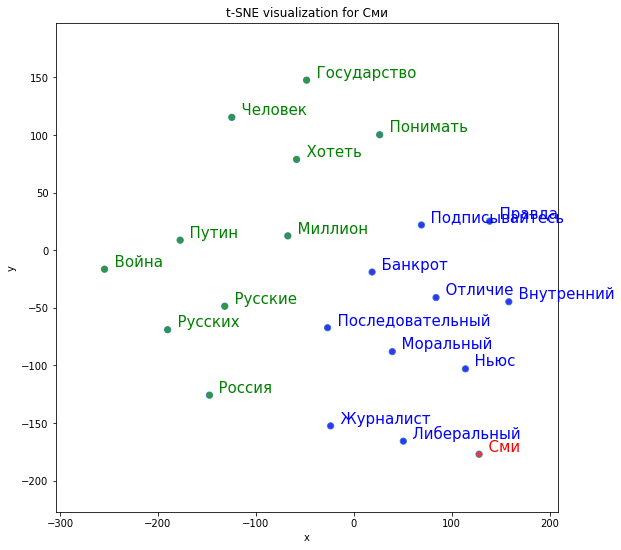

In [68]:
tsnescatterplot(w2v_model, word, [i[0] for i in w2v_model.wv.most_similar(negative=[word])])

# Play

In [69]:
#@title Try to generate a sentence similar to a context

if language == 'ru':
  from spacy.lang.ru import Russian
else:
  from spacy.lang.en import English

def generate_sentence(context):
    # Tokenize the context
    doc = nlp(context)
    # Generate the sentence
    sentence = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        # Use Word2Vec to select a similar word
        similar_word = w2v_model.wv.most_similar(positive=[token.lemma_])[0][0]
        # Use the original token's part of speech
        pos = token.pos_
        # Add the similar word to the sentence
        sentence.append(f'{similar_word}/{pos}')
    # Join the tokens to form a sentence
    sentence = ' '.join(sentence)
    # Capitalize the first letter of the sentence
    sentence = sentence.capitalize()
    # Add a period to the end of the sentence
    sentence += '.'
    return sentence

# Example usage
context = 'Сми моральный банкрот'
generated_sentence = generate_sentence(context)
print(generated_sentence)

Либеральный/noun учёный/adj редакторский/noun.
